In [1]:
import os
os.chdir('C:/Users/will_/OneDrive/Documentos/GitHub/Light_Domain_Adaptation/pixmatch')


In [2]:
# !pip install albumentations tqdm tensorboard
# !pip install hydra-core --pre
# !pip install wandb
# !pip install torch
# !pip install pickle5
# !pip install source
# !pip install dataloaders


In [3]:
from omegaconf import OmegaConf, DictConfig
def load_config_from_yaml(yaml_file: str) -> DictConfig:
    # Carregar o arquivo YAML em um DictConfig
    config = OmegaConf.load(yaml_file)
    return config

# Carregar a configuração
config = load_config_from_yaml('C:/Users/will_/OneDrive/Documentos/GitHub/Light_Domain_Adaptation/pixmatch/configs/GTA5toCITYSCAPE.yaml')

Data loader GTA5 e Cityscape

In [11]:
import os
import random
import logging
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm, trange
import numpy as np

import hydra
from omegaconf import OmegaConf, DictConfig
from torch.utils.tensorboard import SummaryWriter

from datasets.cityscapes_Dataset import City_Dataset, inv_preprocess, decode_labels
from datasets.gta5_Dataset import GTA5_Dataset
from datasets.Brasil_Dataset import Brasil_Dataset
from datasets.synthia_Dataset import SYNTHIA_Dataset
from perturbations.augmentations import augment, get_augmentation
from perturbations.fourier import fourier_mix
from perturbations.cutmix import cutmix_combine
from models import get_model
from models.ema import EMA
from utils.eval import Eval, synthia_set_16, synthia_set_13

In [12]:
source_train_dataset = GTA5_Dataset(split='train', **config.data.source.kwargs)
source_val_dataset = GTA5_Dataset(split='val', **config.data.source.kwargs)

target_train_dataset = City_Dataset(split='train', **config.data.target.kwargs)
target_val_dataset = City_Dataset(split='val', **config.data.target.kwargs)

source_dataloader = DataLoader(
            source_train_dataset, shuffle=True, drop_last=True, **config.data.loader.kwargs)
source_val_dataloader = DataLoader(
            source_val_dataset, shuffle=False, drop_last=False, **config.data.loader.kwargs)

target_dataloader = DataLoader(
            target_train_dataset, shuffle=True, drop_last=True, **config.data.loader.kwargs)
target_val_dataloader = DataLoader(
            target_val_dataset, shuffle=False, drop_last=False, **config.data.loader.kwargs)

C:\Users\will_\OneDrive\Documentos\GitHub\Light_Domain_Adaptation\datasets\GTA5Dataset\gta5_list\train.txt
12403 num images in GTA5 train set have been loaded.
C:\Users\will_\OneDrive\Documentos\GitHub\Light_Domain_Adaptation\datasets\GTA5Dataset\gta5_list\val.txt
6382 num images in GTA5 val set have been loaded.
2975 num images in Cityscapes train set have been loaded.
500 num images in Cityscapes val set have been loaded.


In [13]:
img, target, item = source_train_dataset[100]

In [14]:
target.shape, img.shape

(torch.Size([720, 1280]), torch.Size([3, 720, 1280]))

In [15]:
img, target, item = target_train_dataset[103]

In [16]:
target.shape


torch.Size([640, 1280])

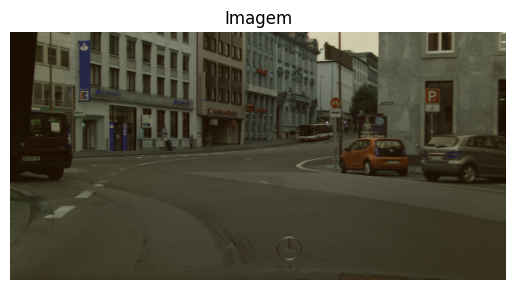

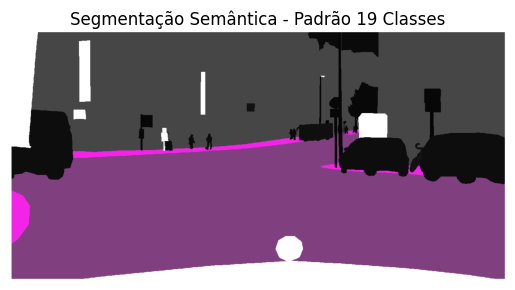

In [19]:
# prompt: visualizar as imanges e targets das celulas anteriores

import matplotlib.pyplot as plt

# Visualizar a imagem
plt.imshow(inv_preprocess(img).permute(1, 2, 0))  # Permutar as dimensões para (H, W, C)
plt.axis('off')
plt.title("Imagem")
plt.show()

# Visualizar o target
plt.imshow(decode_labels(target).squeeze())  # Remover a dimensão extra e usar mapa de cores em escala de cinza
plt.axis('off')
plt.title("Segmentação Semântica - Padrão 19 Classes")
plt.show()


CityScapeBrasil

In [14]:
config = load_config_from_yaml('/content/drive/MyDrive/TCC/LIGHT_ADAPTATION_DOMIAN/pixmatch/configs/brazil.yaml')

In [15]:
source_train_dataset = Brasil_Dataset(split='train', **config.data.target.kwargs)
source_val_dataset = Brasil_Dataset(split='val', **config.data.target.kwargs)
source_dataloader = DataLoader(
            source_train_dataset, shuffle=True, drop_last=True, **config.data.loader.kwargs)
source_val_dataloader = DataLoader(
            source_val_dataset, shuffle=False, drop_last=False, **config.data.loader.kwargs)


17188 num images in Brazil train set have been loaded.
2149 num images in Brazil val set have been loaded.


In [16]:
from PIL import Image, ImageFile
gt_image = Image.new("RGB", (100, 100), (0, 0, 0))
gt_image.size

(100, 100)

In [17]:
img, targetBrazil, item = source_train_dataset[100]

In [18]:
targetBrazil.shape, img.shape

(torch.Size([368, 512]), torch.Size([3, 368, 512]))

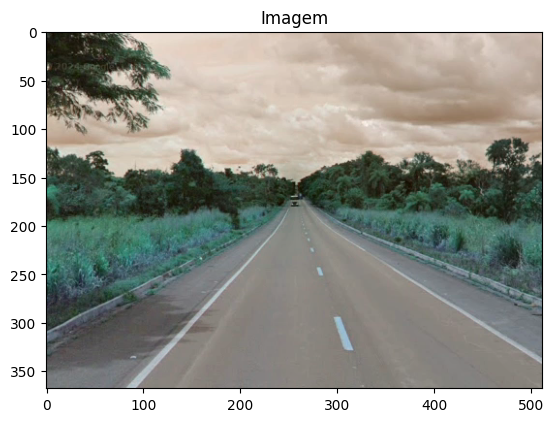

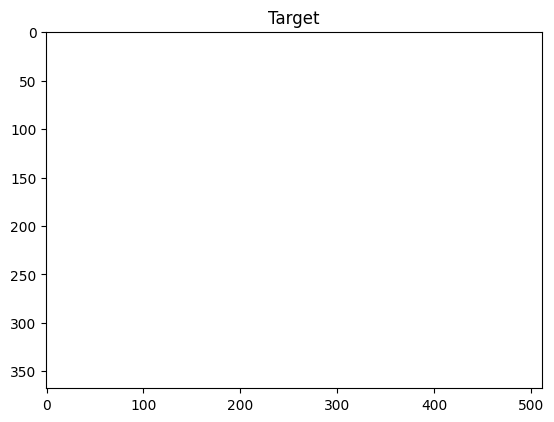

In [19]:
# prompt: visualizar as imanges e targets das celulas anteriores

import matplotlib.pyplot as plt

# Visualizar a imagem
plt.imshow(inv_preprocess(img).permute(1, 2, 0))  # Permutar as dimensões para (H, W, C)
plt.title("Imagem")
plt.show()

# Visualizar o target
plt.imshow(decode_labels(targetBrazil).squeeze())  # Remover a dimensão extra e usar mapa de cores em escala de cinza
plt.title("Target")
plt.show()


In [20]:
# prompt: visualizar as imanges e targets das celulas anteriores

import matplotlib.pyplot as plt


for i in range(len(target_train_dataset)):

  img, target, item = target_train_dataset[i]

  # Crie uma figura com dois subplots
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Plote a imagem no primeiro subplot
  axes[0].imshow(inv_preprocess(img).permute(1, 2, 0))
  axes[0].set_title('Imagem')
  axes[0].axis('off')

  # Plote o target no segundo subplot
  axes[1].imshow(decode_labels(target).squeeze())
  axes[1].set_title('Target')
  axes[1].axis('off')

  # Ajuste o layout e exiba o gráfico
  plt.tight_layout()
  plt.show()


Output hidden; open in https://colab.research.google.com to view.